# Overlay of microwave and optical remote sensing dataset

Both datasets are projected onto the same dataset
- Input coordinate system for X and Y (EPSG: 3413): WGS 84 / NSIDC Sea Ice Polar Stereographic North
- Output coordinate system for long and lat (EPSG: 4468): Cartesian 2D CS for north polar azimuthal lonO 45°W. Axes: X,Y. Orientations: X along 45°E, Y along 135°E meridians. UoM: m.

Useful links:
- info about ESG:3413: https://epsg.io/3413
- info about EPSG:4468: https://epsg.io/4468-cs
- UI to play around with CRS coordinates: https://epsg.io/map#srs=3413&x=944379.792439&y=-944379.792439&z=2&layer=streets

In [61]:
import matplotlib.pyplot as plt
import numpy as np

import rioxarray
import xarray
import rasterio


%matplotlib inline

## Tasks:
1. overlay
2. analyse and look at thresholds -> compare, do boundaries based on melting (0.64) threshold
3. boudaries for plot? # https://rasterio.readthedocs.io/en/latest/topics/plotting.html

### Load data

In [104]:
mw_path = r"..\Data\microwave-rs\CumJour-North-ssmi-1979-2022-H19.nc"
opt_path = r"../Data/optical-rs/2019-06-08_grain_diameter.tif"

In [105]:
data_mw = xarray.open_dataset(mw_path).rio.write_crs("epsg:3413", inplace=True) # add EPSG
data_mw = data_mw.where(data_mw["time"] == np.datetime64('2019-06-08'), drop=True)["melt"] # only use one day for now
data_opt = xarray.open_dataarray(opt_path)

### Compare both datasets (only using 2019-06-08 for now)

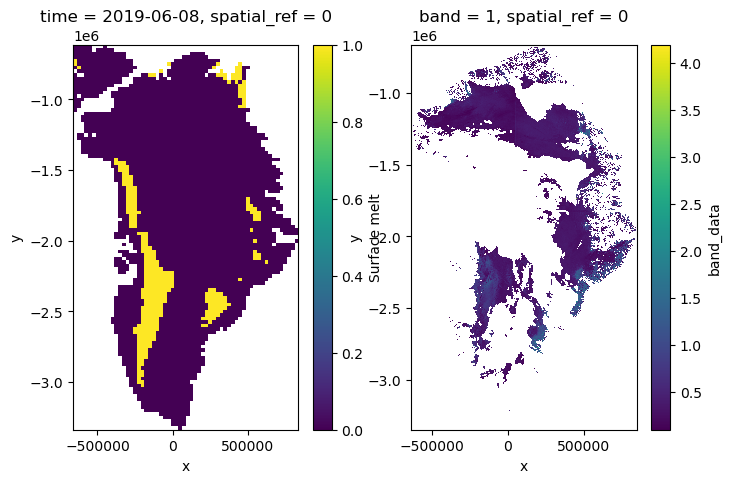

In [81]:
fig, axes = plt.subplots(ncols=2, figsize=(8,5))
data_mw.plot(ax=axes[0])
data_opt.plot(ax=axes[1])
plt.draw()

In [82]:
def print_raster(raster):
    print(
        f"shape: \n   Y: {raster.rio.shape[0]} \n   X: {raster.rio.shape[1]}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: \n   minx = {raster.rio.bounds()[0]} \n   miny = {raster.rio.bounds()[1]} \n   maxx = {raster.rio.bounds()[2]} \n   maxy = {raster.rio.bounds()[3]}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )


print("Microwave Raster:\n----------------")
print_raster(data_mw)
print("Optical Raster:\n----------------")
print_raster(data_opt)

Microwave Raster:
----------------
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662500.0 
   miny = -3337500.0 
   maxx = 837500.0 
   maxy = -612500.0
sum: 358.0
CRS: EPSG:3413

Optical Raster:
----------------
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413



### Reproject microwave dataset match the resolution, projection, and region of  optical dataset

In [101]:
data_repr_mw = data_opt.rio.reproject_match(data_mw)

print("Reprojected Raster:\n-------------------")
print_raster(data_repr_mw)

Reprojected Raster:
-------------------
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662500.0 
   miny = -3337500.0 
   maxx = 837500.0 
   maxy = -612500.0
sum: 535.418212890625
CRS: EPSG:3413



In [107]:
data_repr_mw

<xarray.DataArray 'band_data' (band: 1, y: 109, x: 60)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -6.5e+05 -6.25e+05 -6e+05 ... 8e+05 8.25e+05
  * y            (y) float64 -6.25e+05 -6.5e+05 ... -3.3e+06 -3.325e+06
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area

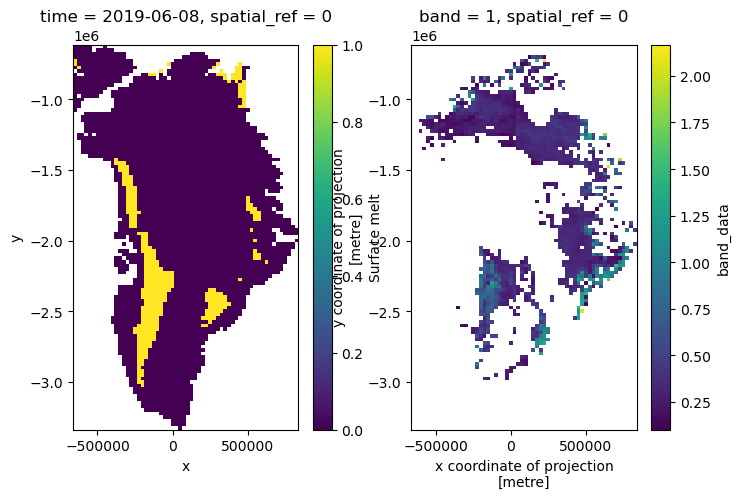

In [103]:
fig, axes = plt.subplots(ncols=2, figsize=(8,5))
data_mw.plot(ax=axes[0])
data_repr_mw.plot(ax=axes[1])
plt.draw()

### Sum up band of reprojected data and microwave data

In [113]:
data_repr_mw = data_repr_mw.assign_coords({
    "x": data_mw.x,
    "y": data_mw.y,
})
data_sum = data_repr_mw + data_mw

In [115]:
print("Sum Raster:\n-----------")
print_raster(data_sum)

Sum Raster:
-----------
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662500.0 
   miny = -3337500.0 
   maxx = 837500.0 
   maxy = -612500.0
sum: 674.22021484375
CRS: EPSG:3413



The brighter the color in the right plot, the more accordance regarding melting between both datasets

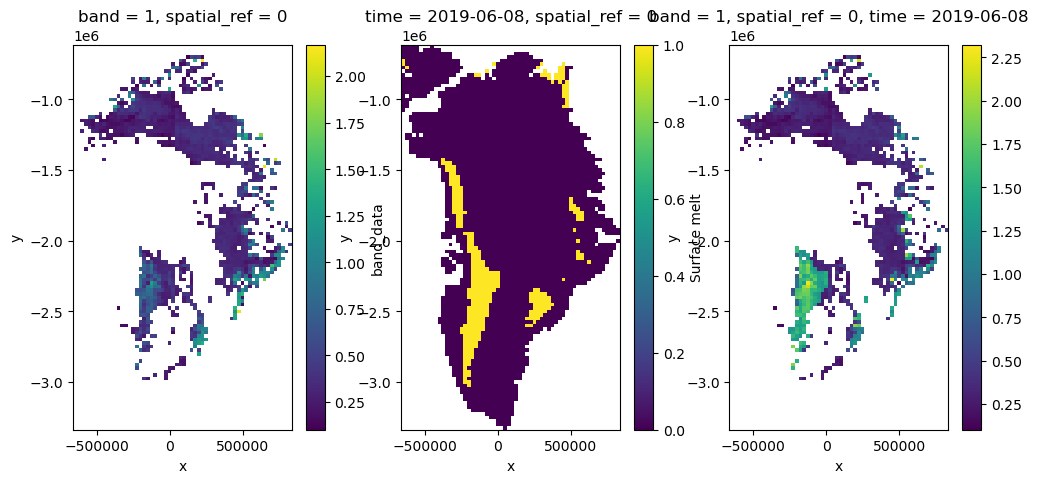

In [119]:
fig, axes = plt.subplots(ncols=3, figsize=(12,5))

data_repr_mw.plot(ax=axes[0])
data_mw.plot(ax=axes[1])
data_sum.plot(ax=axes[2])

plt.draw()